In [ ]:
import os
import sys
ngames_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'ngames/evaluation'))
sys.path.append(ngames_path)

In [2]:
import matplotlib.pyplot as plt
from extensivegames import ExtensiveFormGame, plot_game
from build import build_full_game, build_game_from_rule_combination
from equilibrium import minimize_incentives, subgame_perfect_equilibrium, outcome_probability
from networkx.algorithms.shortest_paths.generic import shortest_path

# Default configuration

Both fishers start at the shore. They can go to one of two fishing spots. If fishers go to different spots, they stay there. If they go to the same spot, they can choose to stay or leave. If, even after then, both fishers end up at the same spot, they fight. The probability of any fisher $i$ winning the fight is given by:

\begin{equation}
P\left[\text{$i$ wins fight}\right]=\frac{S_i}{\sum_j S_j}
\end{equation}

where $S_i$ denotes the strength of fisher $i$, a parameter between 1 (weakest) and 10 (strongest).

To assign the utilities at the terminal nodes of the games, we associate the following actions and outcomes with some payoff:

* Travel between spots: $c<0$.

* Fish alone at spot $i$ / win fight over spot $i$: $v_i$, with $v_1>v_2$.

* Loose a fight: $d<0$.

In [3]:
def assign_utilities(game, c, v1, v2, d):
    for z in game.game_tree.terminal_nodes:
        u = {p:0 for p in game.players}
        
        # get the location of players and loosers of fights
        player_locations = {}
        won_fight = None
        for f in game.state_fluents[z]:
            x1 = f.split('(')
            predicate = x1[0]
            arguments = x1[1].split(', ')
            arguments[-1] = arguments[-1][:-1]
            if predicate == 'at':
                player_locations[arguments[0]] = arguments[1]
            elif predicate == 'won_fight':
                won_fight = arguments[0]
        
        # utilities for losing or winning fight
        if won_fight:
            for p in game.players:
                if p != won_fight:
                    u[p] += d
                else:
                    spot = player_locations[p]
                    u[p] += v1 if spot == 'spot1' else v2
        
        # utilities for being alone at a spot
        if player_locations['alice'] != player_locations['bob']:
            alice_spot = player_locations['alice']
            u['alice'] += v1 if alice_spot == 'spot1' else v2
            u['bob'] += v2 if alice_spot == 'spot1' else v1

        # cost for switching spots
        path_from_root = shortest_path(game.game_tree, game.game_tree.root, z)
        for i in range(len(path_from_root)-1):
            a = game.game_tree.get_edge_data(path_from_root[i], path_from_root[i+1])['action']
            if a == 'leave':
                p = game.turn_function[path_from_root[i]]
                u[p] += c
                
        game.set_utility(z, u)        

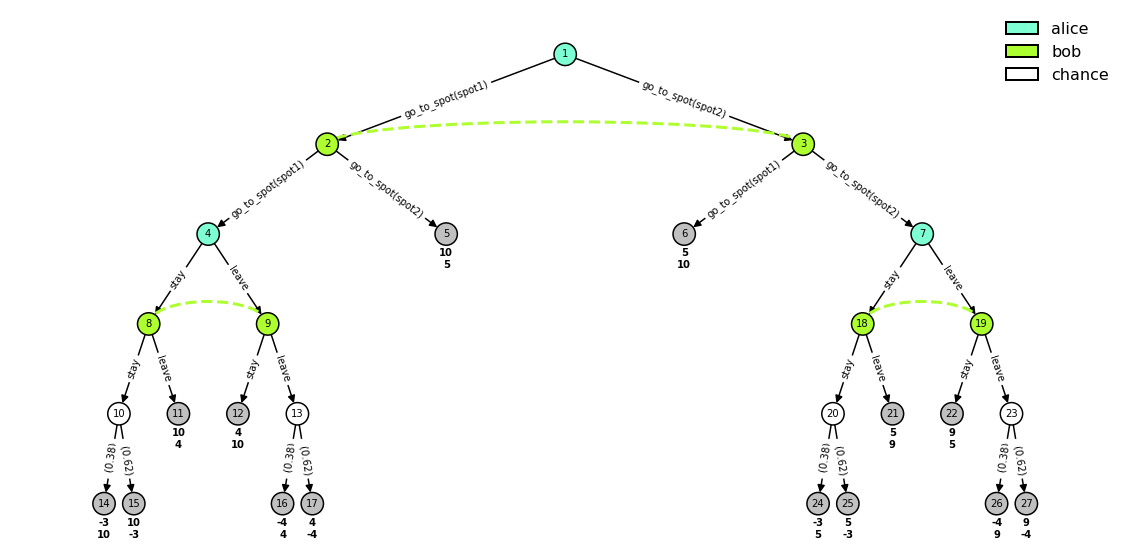

In [4]:
game = build_game_from_rule_combination('.', 'fishers', {'n1':-1, 'n2':-1}, utility_assignment_function=assign_utilities, utility_function_kwargs={'v1':10, 'v2':5, 'c':-1, 'd':-3})

my_fig_kwargs = dict(figsize=(20,10), frameon=False)
my_node_kwargs = dict(font_size=10, node_size=500, edgecolors='k', linewidths=1.5)
my_edge_kwargs = dict(arrowsize=15, width=1.5)
my_edge_labels_kwargs = dict(font_size=10)
my_patch_kwargs = dict(linewidth=2)
my_legend_kwargs = dict(fontsize=16, loc='upper right', edgecolor='white')
my_info_sets_kwargs = dict(linestyle='--', linewidth=3)
my_utility_label_kwargs = dict(horizontalalignment='center', fontsize=10, weight='bold')

position_colors =  {'alice':'aquamarine', 'bob':'greenyellow'}

fig = plot_game(game,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.08,
                decimals=0,
                info_sets_kwargs=my_info_sets_kwargs)

In [5]:
# fig.savefig('/home/nmontes/OneDrive/Documentos/PhD/action-situation-language/figures/fishers_default.png', bbox_inches='tight', dpi=400)

In [6]:
for n, f in game.state_fluents.items():
    f.sort()
    print("{} -- {}".format(n, ', '.join(f)))

1 -- at(alice, shore), at(bob, shore)
4 -- at(alice, spot1), at(bob, spot1)
5 -- at(alice, spot1), at(bob, spot2)
6 -- at(alice, spot2), at(bob, spot1)
7 -- at(alice, spot2), at(bob, spot2)
14 -- at(alice, spot1), at(bob, spot1), won_fight(bob)
15 -- at(alice, spot1), at(bob, spot1), won_fight(alice)
11 -- at(alice, spot1), at(bob, spot2)
12 -- at(alice, spot2), at(bob, spot1)
16 -- at(alice, spot2), at(bob, spot2), won_fight(bob)
17 -- at(alice, spot2), at(bob, spot2), won_fight(alice)
24 -- at(alice, spot2), at(bob, spot2), won_fight(bob)
25 -- at(alice, spot2), at(bob, spot2), won_fight(alice)
21 -- at(alice, spot2), at(bob, spot1)
22 -- at(alice, spot1), at(bob, spot2)
26 -- at(alice, spot1), at(bob, spot1), won_fight(bob)
27 -- at(alice, spot1), at(bob, spot1), won_fight(alice)


In [7]:
subgame_mixed_strat, back_utilities, incentives = subgame_perfect_equilibrium(game, minimize_incentives)

outcome_prob = {t: outcome_probability(game, subgame_mixed_strat, t) for t in game.game_tree.terminal_nodes}
expected_utilities = {p: 0 for p in game.players}

for n, p in outcome_prob.items():
    for player in game.players:
        expected_utilities[player] += p*game.utility[n][player]
    print("{} -- {}".format(n, p))
    
print(expected_utilities)
print(sum(outcome_prob.values()))

5 -- 0.008217281616549603
6 -- 0.21458685016342113
11 -- 1.5223685934676118e-18
12 -- 0.12454825181135931
14 -- 0.2438895488556171
15 -- 0.40648258142602844
16 -- 1.0932684041603915e-19
17 -- 1.8221140069339855e-19
21 -- 0.0006359976940105618
22 -- 0.000173325548847367
24 -- 2.9811051281460615e-05
25 -- 4.9685085469101024e-05
26 -- 0.0005200000302810071
27 -- 0.0008666667171350121
{'alice': 4.997076152937744, 'bob': 4.659689112502959}
1.0


In [8]:
violent_outcomes = [14, 15, 16, 17,24, 25, 26, 27]
violent_outcomes_probs = [outcome_prob[t] for t in violent_outcomes]
violence_prob = sum(violent_outcomes_probs)
print(violence_prob)

0.651838293165812


# *First-in-time, first-in-right* configuration

Now fishers also start from the shore, but if they go to the same fishing spot, the fisher who gets there first is commited to the spot, while the fisher who has lost the race has to leave. The probability that fisher $i$ wins the race if both fishers go to the same spot is:

\begin{equation}
P(\text{$i$ wins race}) = \frac{V_i}{\sum_j V_j}
\end{equation}

where $V_i$ denotes the speed of fisher $i$, a parameter between 1 (slowest) and 10 (fastest).

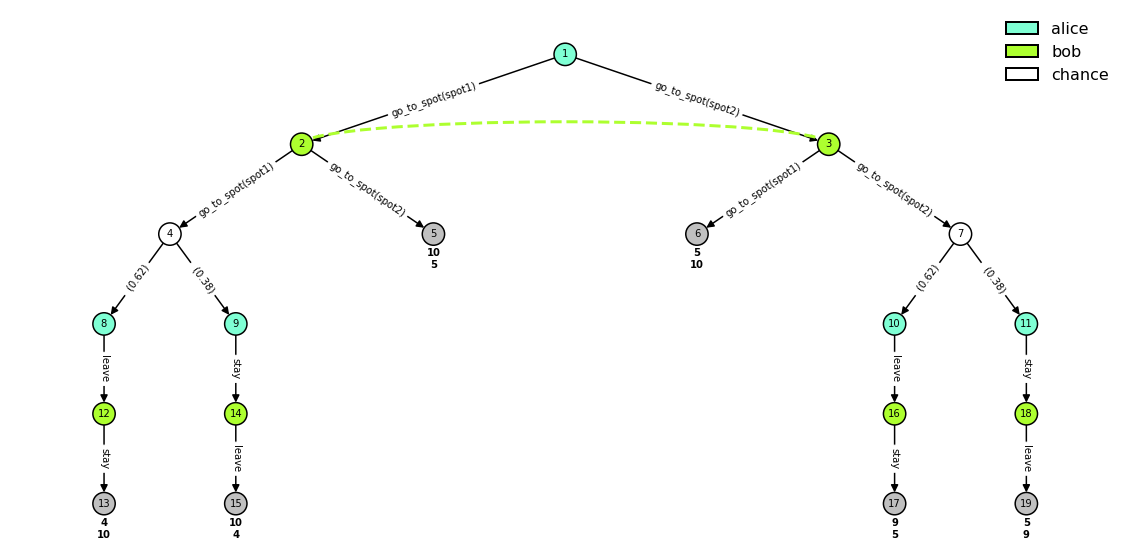

In [9]:
game = build_game_from_rule_combination('.', 'fishers', {'n1':1, 'n2':-1}, utility_assignment_function=assign_utilities, utility_function_kwargs={'v1':10, 'v2':5, 'c':-1, 'd':-3})

fig = plot_game(game,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.08,
                decimals=0,
                info_sets_kwargs=my_info_sets_kwargs)

In [10]:
# fig.savefig('/home/nmontes/OneDrive/Documentos/PhD/action-situation-language/figures/fishers_race.png', bbox_inches='tight', dpi=400)

In [11]:
for n, f in game.state_fluents.items():
    f.sort()
    print("{} -- {}".format(n, ', '.join(f)))

1 -- at(alice, shore), at(bob, shore)
8 -- at(alice, spot1), at(bob, spot1), won_race(bob)
9 -- at(alice, spot1), at(bob, spot1), won_race(alice)
5 -- at(alice, spot1), at(bob, spot2)
6 -- at(alice, spot2), at(bob, spot1)
10 -- at(alice, spot2), at(bob, spot2), won_race(bob)
11 -- at(alice, spot2), at(bob, spot2), won_race(alice)
13 -- at(alice, spot2), at(bob, spot1), won_race(bob)
15 -- at(alice, spot1), at(bob, spot2), won_race(alice)
17 -- at(alice, spot1), at(bob, spot2), won_race(bob)
19 -- at(alice, spot2), at(bob, spot1), won_race(alice)


In [12]:
subgame_mixed_strat, back_utilities, incentives = subgame_perfect_equilibrium(game, minimize_incentives)

outcome_prob = {t: outcome_probability(game, subgame_mixed_strat, t) for t in game.game_tree.terminal_nodes}
expected_utilities = {p: 0 for p in game.players}

for n, p in outcome_prob.items():
    for player in game.players:
        expected_utilities[player] += p*game.utility[n][player]
    print("{} -- {}".format(n, p))

print(expected_utilities)

5 -- 0
6 -- 0
13 -- 0.6153846153846154
15 -- 0.38461538461538464
17 -- 0
19 -- 0
{'alice': 6.307692307692308, 'bob': 7.6923076923076925}


In [13]:
import math

n = 10
s = 0

for k in range(n+1):
    s += 1/math.factorial(n-k)
s *= math.factorial(n)
print(s)

9864101.0


# *First-to-announce, first-in-right* configuration

In this configuration, one of the fishers is randomly assigned to the position of announcer. When both fishers are in the shore, anyone can go to any spot before the announcer has declared to one spot. Then, both fishers can go to any of the spots. If the fishers both go the spot that the announcer has declared, the announcer is guaranted to win the race to the spot. If the fishers both go to the spot that has not been declared by the announcer, any of them might win the race to get there. The winner of the race is commited to the spot (she stays) while the looser has to leave.

Note that the rules for this configuration are *in addition* to the *first-in-time, first-in-right* rules, and they have been assigned priority 2 (*first-in-time, first-in-right* rules where assigned priority 1, and the default rules were assigned priority 0, as usual).

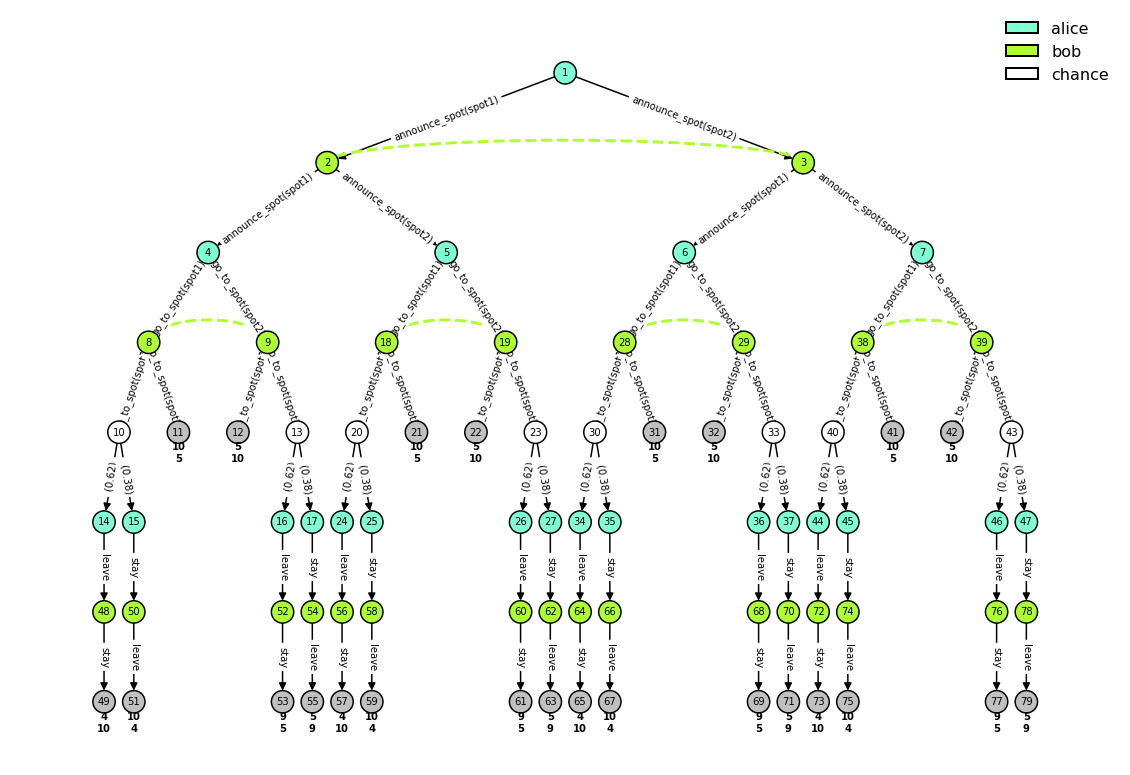

In [14]:
game = build_game_from_rule_combination('.', 'fishers', {'n1':2, 'n2':1}, utility_assignment_function=assign_utilities, utility_function_kwargs={'v1':10, 'v2':5, 'c':-1, 'd':-3})

my_fig_kwargs = dict(figsize=(20,14), frameon=False)
fig = plot_game(game,
                position_colors,
                fig_kwargs=my_fig_kwargs,
                node_kwargs=my_node_kwargs,
                edge_kwargs=my_edge_kwargs,
                edge_labels_kwargs=my_edge_labels_kwargs,
                patch_kwargs=my_patch_kwargs,
                legend_kwargs=my_legend_kwargs,
                utility_label_kwargs=my_utility_label_kwargs,
                utility_label_shift=0.07,
                decimals=0,
                info_sets_kwargs=my_info_sets_kwargs)

In [15]:
# fig.savefig('/home/nmontes/OneDrive/Documentos/PhD/action-situation-language/figures/fishers_announce.png', bbox_inches='tight', dpi=400)

In [16]:
for n, f in game.state_fluents.items():
    f.sort()
    print("{} -- {}".format(n, ', '.join(f)))

1 -- at(alice, shore), at(bob, shore)
4 -- announced(alice, spot1), announced(bob, spot1), at(alice, shore), at(bob, shore)
5 -- announced(alice, spot1), announced(bob, spot2), at(alice, shore), at(bob, shore)
6 -- announced(alice, spot2), announced(bob, spot1), at(alice, shore), at(bob, shore)
7 -- announced(alice, spot2), announced(bob, spot2), at(alice, shore), at(bob, shore)
14 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot1), at(bob, spot1), won_race(bob)
15 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot1), at(bob, spot1), won_race(alice)
11 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot1), at(bob, spot2)
12 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot2), at(bob, spot1)
16 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot2), at(bob, spot2), won_race(bob)
17 -- announced(alice, spot1), announced(bob, spot1), at(alice, spot2), at(bob, spot2), won_race(alice)
24 -- announced(alice, spot1), a

In [17]:
subgame_mixed_strat, back_utilities, incentives = subgame_perfect_equilibrium(game, minimize_incentives)

outcome_prob = {t: outcome_probability(game, subgame_mixed_strat, t) for t in game.game_tree.terminal_nodes}
expected_utilities = {p: 0 for p in game.players}

for n, p in outcome_prob.items():
    for player in game.players:
        expected_utilities[player] += p*game.utility[n][player]
    print("{} -- {}".format(n, p))

print(expected_utilities)

11 -- 0
12 -- 0
21 -- 0
22 -- 0
31 -- 0
32 -- 0
41 -- 0
42 -- 0
49 -- 0.15384615384615385
51 -- 0.09615384615384616
53 -- 0
55 -- 0
57 -- 0.15384615384615385
59 -- 0.09615384615384616
61 -- 0
63 -- 0
65 -- 0.15384615384615385
67 -- 0.09615384615384616
69 -- 0
71 -- 0
73 -- 0.15384615384615385
75 -- 0.09615384615384616
77 -- 0
79 -- 0
{'alice': 6.307692307692308, 'bob': 7.692307692307693}
